# Initial Data Processing
Importing the raw data from various sources and turning it into tabular results, one election result per row.  

Where does political power reside in the US?
Where does political power reside in the United States?
Which US locations are most politically powerful?
Which locations in the US are the most politically powerful?

In [1]:
import os
import pandas as pd
import numpy as np
import string

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

matplotlib.style.use('ggplot')

# Power Sharing Model

Might make political scientist pull their hair out, but here it is.  

In [2]:
# Eventually use this to reduce all dataframes
# so any year can be used for analysis
election_year = 2018

# Power sharing model
total_power = 100

federal_power = 0.5*total_power
president_power = 0.5*federal_power
senate_power = 0.25*federal_power
senator_power = senate_power/100 #Fixed
house_power = 0.25*federal_power
houserep_power = house_power/435 #Fixed

states_power = 0.5*total_power
governor_power = 0.5*states_power
state_senate_power = 0.25*states_power
state_house_power = 0.25*states_power

In [3]:
state_path = os.path.join(os.getcwd(), 'data', 'misc', 'state_metadata.csv')
state_df = pd.read_csv(state_path, dtype={'fips': 'str'})
state_df.head()

,fips,state_abbr,state_name,pop_2018,electoral_votes_2016
0,01,AL,Alabama,4887871,9
1,02,AK,Alaska,737438,3
2,04,AZ,Arizona,7171646,11
3,05,AR,Arkansas,3013825,6
4,06,CA,California,39557045,55


# Presidential Voting Power

In [4]:
prespw_df = state_df[['fips', 'state_abbr', 'electoral_votes_2016']].copy()
prespw_df['power'] = (prespw_df['electoral_votes_2016']
    /prespw_df['electoral_votes_2016'].sum())*president_power
prespw_df['office'] = 'president'
prespw_df.sort_values(by='power', ascending=False).head()

,fips,state_abbr,electoral_votes_2016,power,office
4,06,CA,55,2.555762,president
43,48,TX,38,1.765799,president
9,12,FL,29,1.347584,president
32,36,NY,29,1.347584,president
13,17,IL,20,0.929368,president


In [5]:
pres_path = os.path.join(os.getcwd(), 'data',
    'federal-elections', '1976-2016-president.csv')
pres_df = pd.read_csv(pres_path, dtype={'state_fips': 'str', 
    'state_cen': 'str','state_ic': 'str'})
pres_df = pres_df[
    (pres_df.year == 2016) & 
    (pres_df.party.isin(['republican', 'democrat']))  #Need to exclude write-ins as well, below
]
pres_df = pres_df.groupby(by=['year', 'state_fips', 'party']) \
    .agg({'totalvotes':'mean', 'candidatevotes':'max'})  #Max excludes multiple Rs
pres_df.reset_index(inplace=True)

# Equivalent of unstacking by party, but needed custom code
tmp1_df = pres_df[pres_df.party == 'democrat'].copy()
tmp1_df.rename(columns={'candidatevotes':'dem'}, inplace=True)
tmp1_df.drop('party', axis=1, inplace=True)
tmp2_df = pres_df[pres_df.party == 'republican'].copy()
tmp2_df.rename(columns={'candidatevotes':'rep'}, inplace=True)
tmp2_df.drop('party', axis=1, inplace=True)
pres_df = tmp1_df.merge(tmp2_df, 
    on=['year', 'state_fips', 'totalvotes'])
pres_df['dem_margin'] = ((pres_df.dem-pres_df.rep)/pres_df.totalvotes)*100
pres_df.rename(columns={'state_fips': 'fips'}, inplace=True)

# Merge with power_df, calculate voting_power based on margin
pres_df = pres_df[['year','fips', 'dem_margin']]
pres_df = pres_df.merge(prespw_df[['fips', 'power', 'state_abbr', 'office']], on='fips')
pres_df['abs_margin'] = pres_df.dem_margin.abs()
pres_df['voting_power'] = pres_df.power/pres_df.abs_margin
pres_df.rename(columns={'fips':'geoid'}, inplace=True)
# Problem with the following metric is states can't overperform their ceiling:
# pres_df['voting_power'] = pres_df.power/(1-pres_df.dem_margin.abs()/100)
pres_df.sort_values(by='voting_power', ascending=False).head(10)

,year,geoid,dem_margin,power,state_abbr,office,abs_margin,voting_power
22,2016,26,-0.223033,0.743494,MI,president,0.223033,3.333558
38,2016,42,-0.724270,0.929368,PA,president,0.724270,1.283180
9,2016,12,-1.198626,1.347584,FL,president,1.198626,1.124274
49,2016,55,-0.764343,0.464684,WI,president,0.764343,0.607952
29,2016,33,0.367596,0.185874,NH,president,0.367596,0.505647
23,2016,27,1.519841,0.464684,MN,president,1.519841,0.305745
43,2016,48,-8.999428,1.765799,TX,president,8.999428,0.196212
33,2016,37,-3.655229,0.697026,NC,president,3.655229,0.190693
10,2016,13,-5.131343,0.743494,GA,president,5.131343,0.144893
2,2016,04,-3.545595,0.511152,AZ,president,3.545595,0.144165


In [6]:
pres_df['voting_power'].sum()

9.040409812651177

# US Congress

## US Senate Voting Power

In [7]:
senpw_df = state_df[['fips', 'state_abbr']].copy()
senpw_df['power'] = senator_power
senpw_df['office'] = 'ussenate'
senpw_df.head()

,fips,state_abbr,power,office
0,01,AL,0.125,ussenate
1,02,AK,0.125,ussenate
2,04,AZ,0.125,ussenate
3,05,AR,0.125,ussenate
4,06,CA,0.125,ussenate


In [8]:
# Federal senate just follows the state FIPS codes, will attach to geographies
# using these. 
sen_path = os.path.join(os.getcwd(), 'data',
    'federal-elections', '1976-2016-senate.csv')
sen_df = pd.read_csv(sen_path, dtype={'state_fips': 'str'})
sen2018_path = os.path.join(os.getcwd(), 'data',
    'federal-elections', 'senate_overall_2018.csv')
sen2018_df = pd.read_csv(sen2018_path, dtype={'state_fips': 'str'})
# Add leading zeros
sen2018_df['state_fips'] = sen2018_df['state_fips'].str.zfill(2)
sen_df = sen_df.append(sen2018_df, sort=True)
sen_df = sen_df[sen_df.special == False]  #Remove special elections for now 
sen_df.rename(columns={'state_fips': 'fips'}, inplace=True)
sen_df.reset_index(inplace=True, drop=True)
sen_df = sen_df[['candidatevotes', 'party', 
    'state_po', 'fips', 'year', 'totalvotes']]

# Filter down dataframe to last two state elections
f = sen_df['year'].max()
years = [f, f-2, f-4]
sen_df = sen_df[sen_df.year.isin(years)]

# Iterate through groups of candidates, selecting the top 2
# and calcualting the winning margin between them.  
groups = sen_df.groupby(by=['state_po','year','totalvotes']).groups
cols = ['year', 'fips', 'dem_margin', 'abs_margin']
results_df = pd.DataFrame(columns=cols)
for key, values in groups.items():
    # Take the top two vote getters off the top:
    sub_df = sen_df.loc[values].sort_values(by='candidatevotes', 
        ascending=False).head(2)
    indices = sub_df.index.values
    tmp_df = sen_df.loc[indices[0]].copy()
    tmp_df = tmp_df[['year', 'fips']]
    # If the pair follow standard dem/rep lines, calculate dem
    # margin, otherwise just calculate absolute margin for use 
    # in the power calculation later.
    # Someone ran unopposed
    if len(indices) == 1: 
        party = sub_df.loc[indices[0]].party
        if party == 'democrat':
            tmp_df['dem_margin'] = 100
        elif party == 'republican':
            tmp_df['dem_margin'] = -100
        else:
            tmp_df['dem_margin'] = np.nan
        tmp_df['abs_margin'] = abs(((sub_df.loc[indices[0]].candidatevotes - 0)
            / sub_df.loc[indices[0]].totalvotes) * 100)
    # Traditional D/R race:
    elif set(sub_df.party) == set(['republican', 'democrat']):
        sub_df = sub_df.set_index('party')
        tmp_df['dem_margin'] = ((sub_df.loc['democrat'].candidatevotes
            - sub_df.loc['republican'].candidatevotes) 
            / sub_df.loc['democrat'].totalvotes) * 100
        tmp_df['abs_margin'] = abs(tmp_df['dem_margin'])
    # Handles states that have open primaries, e.g. CA:
    elif ((set(sub_df.party) == set(['democrat', 'democrat'])) or 
          (set(sub_df.party) == set(['republican', 'republican']))):
        if set(sub_df.party) == set(['democrat', 'democrat']):
            tmp_df['dem_margin'] = 100
            tmp_df['abs_margin'] = 100
        elif set(sub_df.party) == set(['republican', 'republican']):
            tmp_df['dem_margin'] = -100
            tmp_df['abs_margin'] = 100
    else:
        tmp_df['dem_margin'] = np.nan
        tmp_df['abs_margin'] = abs(((sub_df.loc[indices[0]].candidatevotes
            - sub_df.loc[indices[1]].candidatevotes) 
            / sub_df.loc[indices[0]].totalvotes) * 100)
    results_df = results_df.append(tmp_df, sort=True)

sen_df = results_df.merge(senpw_df, on='fips')
sen_df.rename(columns={'fips': 'geoid'}, inplace=True)
sen_df['voting_power'] = sen_df['power']/sen_df['abs_margin']
sen_df.sort_values(by='voting_power', ascending=False).head(10)

,abs_margin,dem_margin,geoid,year,state_abbr,power,office,voting_power
5,0.122503,-0.122503,12,2018,FL,0.125,ussenate,1.020383
60,0.137592,0.137592,33,2016,NH,0.125,ussenate,0.908481
73,0.811500,0.811500,51,2014,VA,0.125,ussenate,0.154036
49,1.432453,-1.432453,42,2016,PA,0.125,ussenate,0.087263
32,1.564446,-1.564446,37,2014,NC,0.125,ussenate,0.079900
16,1.944482,-1.944482,08,2014,CO,0.125,ussenate,0.064284
86,2.129603,-2.129603,02,2014,AK,0.125,ussenate,0.058696
83,2.344496,2.344496,04,2018,AZ,0.125,ussenate,0.053316
56,2.428507,2.428507,32,2016,NV,0.125,ussenate,0.051472
36,2.567246,-2.567246,48,2018,TX,0.125,ussenate,0.048690


In [9]:
#Some elections are dem-dem, some are rep-independent
#So when calculating the power, just calculate the 
#absolute value of the margin between the two.  
#When you show partisan maps, just leave out those
#not falling into the L/R categorization.  
#sen_df.groupby(by='party')['party'].count()
# party
# democrat                   95
# democratic-farmer-labor     1
# democratic-npl              1
# independent                 3
# libertarian                 1
# republican                 98
# Name: party, dtype: int64

In [10]:
sen_df['voting_power'].sum()

3.4148873659307153

## US House Voting Power

In [11]:
# Federal house districts follow this pattern in geodatabase:
# 0101
#Non digits for Federal house are:
#['09ZZ', '17ZZ', '26ZZ']
hs_path = os.path.join(os.getcwd(), 'data',
    'federal-elections', 'district_overall_2018.csv')
hs_df = pd.read_csv(hs_path, dtype={'state_fips': 'str'}) 
hs_df['state_fips'] = hs_df['state_fips'].str.zfill(2)
hs_df['cd'] = hs_df['district'].str.replace(pat='District ', repl='')
hs_df['geoid'] = hs_df['state_fips'] + hs_df['cd'].str.zfill(2)
hs_df = hs_df[hs_df.special == False]  # Remove special elections for now 
# Remove repeated records
hs_df = hs_df.drop_duplicates(subset=['candidate', 'year'], keep='first')

# Filter down dataframe to last elections
f = hs_df['year'].max()
years = [f]
hs_df = hs_df[hs_df.year.isin(years)]

# Iterate through groups of candidates, selecting the top 2
# and calcualting the winning margin between them.  
groups = hs_df.groupby(by=['year','geoid']).groups
cols = ['year', 'geoid', 'dem_margin', 'abs_margin']
results_df = pd.DataFrame(columns=cols)
for key, values in groups.items():
    # Take the top two vote getters off the top:
    sub_df = hs_df.loc[values].sort_values(by='candidatevotes', 
        ascending=False).head(2)
    indices = sub_df.index.values
    tmp_df = hs_df.loc[indices[0]].copy()
    tmp_df = tmp_df[['year', 'geoid']]
    # If the pair follow standard dem/rep lines, calculate dem
    # margin, otherwise just calculate absolute margin for use 
    # in the power calculation later.
    if len(indices) == 1: # Someone ran unopposed
        party = sub_df.loc[indices[0]].party
        if party == 'democrat':
            tmp_df['dem_margin'] = 100
        elif party == 'republican':
            tmp_df['dem_margin'] = -100
        else:
            tmp_df['dem_margin'] = np.nan
        tmp_df['abs_margin'] = abs(((sub_df.loc[indices[0]].candidatevotes - 0) 
            / sub_df.loc[indices[0]].totalvotes) * 100)
    # Traditional D/R race:
    elif set(sub_df.party) == set(['republican', 'democrat']):
        sub_df = sub_df.set_index('party')
        tmp_df['dem_margin'] = ((sub_df.loc['democrat'].candidatevotes
            - sub_df.loc['republican'].candidatevotes) 
            / sub_df.loc['democrat'].totalvotes) * 100
        tmp_df['abs_margin'] = abs(tmp_df['dem_margin'])
    # Handles states that have open primaries, e.g. CA:
    elif ((set(sub_df.party) == set(['democrat', 'democrat'])) or 
          (set(sub_df.party) == set(['republican', 'republican']))):
        if set(sub_df.party) == set(['democrat', 'democrat']):
            tmp_df['dem_margin'] = 100
            tmp_df['abs_margin'] = 100
        elif set(sub_df.party) == set(['republican', 'republican']):
            tmp_df['dem_margin'] = -100
            tmp_df['abs_margin'] = 100
    else:
        tmp_df['dem_margin'] = np.nan
        tmp_df['abs_margin'] = abs(((sub_df.loc[indices[0]].candidatevotes
            - sub_df.loc[indices[1]].candidatevotes) 
            / sub_df.loc[indices[0]].totalvotes) * 100)
        
    results_df = results_df.append(tmp_df, sort=True)

hs_df = results_df.copy()
hs_df['power'] = houserep_power
lookup = state_df[['fips', 'state_abbr']] \
    .set_index('fips').to_dict(orient='index')
hs_df['state_abbr'] = hs_df['geoid'].str[0:2].apply(lambda x: lookup[x]['state_abbr'])
hs_df['voting_power'] = hs_df['power']/hs_df['abs_margin']
hs_df['office'] = 'ushouse'
hs_df.sort_values(by='voting_power', ascending=False).head(10)

,abs_margin,dem_margin,geoid,year,power,state_abbr,voting_power,office
117,0.149408,-0.149408,1307,2018,0.028736,GA,0.192331,ushouse
1308,0.257733,0.257733,4904,2018,0.028736,UT,0.111494,ushouse
1392,0.320108,-0.320108,3709,2018,0.028736,NC,0.089769,ushouse
666,0.440808,-0.440808,4823,2018,0.028736,TX,0.065189,ushouse
1052,0.450866,NaN,2701,2018,0.028736,MN,0.063734,ushouse
27,0.758696,0.758696,0621,2018,0.028736,CA,0.037875,ushouse
200,0.759463,-0.759463,1713,2018,0.028736,IL,0.037837,ushouse
237,0.845902,-0.845902,2002,2018,0.028736,KS,0.033970,ushouse
167,0.874615,0.874615,1226,2018,0.028736,FL,0.032855,ushouse
472,0.907566,0.907566,3624,2018,0.028736,NY,0.031662,ushouse


In [12]:
hs_df['voting_power'].sum()

1.702852481033574

# Governor Voting Power

In [13]:
govpw_df = state_df[['fips', 'state_abbr', 'pop_2018' ]].copy()
# Use fraction of total national population in each state 
# to allocate the 25 points of governor power.  
govpw_df['power'] = (govpw_df['pop_2018']/govpw_df['pop_2018'].sum())*governor_power
govpw_df['office'] = 'governor'
govpw_df.sort_values(by='power', ascending=False).head()

,fips,state_abbr,pop_2018,power,office
4,06,CA,39557045,3.022691,governor
43,48,TX,28701845,2.193208,governor
9,12,FL,21299325,1.627555,governor
32,36,NY,19542209,1.493288,governor
38,42,PA,12807060,0.978632,governor


In [14]:
# Most recent governor's race by state
gov_path = os.path.join(os.getcwd(), 'data', 
    'state-elections', 'governors', 'governors.csv')
gov_df = pd.read_csv(gov_path, dtype={'fips': 'str'})

# Find the indices of the most recent year by state fips
# https://stackoverflow.com/questions/15705630
max_idx = gov_df.groupby(by='fips')['year'].idxmax()
# Reduce the dataframe to most recent years
gov_df = gov_df.loc[max_idx]
gov_df['dem_margin'] = ((gov_df.dem - gov_df.rep) / gov_df.total)*100
gov_df.sort_values(by='dem_margin', ascending=False).head()

gov_df = gov_df[['year','fips','dem_margin']] \
    .merge(govpw_df[['fips', 'state_abbr', 'power', 'office']], on='fips')
gov_df['abs_margin'] = gov_df.dem_margin.abs()
gov_df['voting_power'] = gov_df.power/gov_df.abs_margin
gov_df.rename(columns={'fips':'geoid'}, inplace=True)
gov_df.sort_values(by='voting_power', ascending=False).head(10)

,year,geoid,dem_margin,state_abbr,power,office,abs_margin,voting_power
8,2018,12,-0.394900,FL,1.627555,governor,0.394900,4.121436
32,2016,37,0.218148,NC,0.793448,governor,0.218148,3.637197
9,2018,13,-1.389146,GA,0.803830,governor,1.389146,0.578650
48,2018,55,1.093290,WI,0.444235,governor,1.093290,0.406329
34,2018,39,-3.703961,OH,0.893231,governor,3.703961,0.241156
42,2018,48,-13.298838,TX,2.193208,governor,13.298838,0.164917
4,2018,06,23.897054,CA,3.022691,governor,23.897054,0.126488
14,2018,19,-2.733351,IA,0.241172,governor,2.733351,0.088233
6,2018,09,3.154102,CT,0.273000,governor,3.154102,0.086554
13,2016,18,-5.952019,IN,0.511350,governor,5.952019,0.085912


In [15]:
gov_df['voting_power'].sum()

10.740176002494842

# State Legislatures

In [16]:
cols = ['year','sab', 'sen', 'sfips','dvote', 'dname', 'dno', 'geopost',
    'etype','rvote', 'ovote','dper', 'uncont', 'dontuse']
sl_path = os.path.join(os.getcwd(), 'data', 'state-elections',
    'legislatures', '102slersuoacontest20181024-1.tab' )
sl_df = pd.read_csv(sl_path, sep='\t', usecols=cols, 
    dtype={'year': 'int', 'sfips': 'str', 
        'dno': 'str', 'sen':'int'})
sl_df = sl_df[sl_df.year >= (election_year - 12)] # Limit to past 12 years
sl_df = sl_df[sl_df.etype == 'g'] # Remove special elections
sl_df['sfips'] = sl_df['sfips'].str.zfill(2)
sl_df['dno'] = sl_df['dno'].str.zfill(3)
sl_df.head()

,year,sfips,sab,sen,dname,dno,geopost,etype,dvote,rvote,ovote,dontuse,uncont,dper
105638,2006,01,AL,0,NaN,001,NaN,g,8410.0,4511.0,0.0,0.0,0.0,65.087845
105639,2006,01,AL,0,NaN,002,NaN,g,7704.0,4115.0,0.0,0.0,0.0,65.183180
105640,2006,01,AL,0,NaN,003,NaN,g,9585.0,0.0,0.0,0.0,1.0,100.000000
105641,2006,01,AL,0,NaN,004,NaN,g,5988.0,8097.0,0.0,0.0,0.0,42.513313
105642,2006,01,AL,0,NaN,005,NaN,g,7071.0,5277.0,0.0,0.0,0.0,57.264336


In [17]:
# sl_df[sl_df.sfips == '31']
# Nebraska isn't in this dataset

In [18]:
# Source: http://www.ncsl.org/research/about-state-legislatures/number-of-legislators-and-length-of-terms.aspx
sseats_df = pd.read_csv(os.path.join(os.getcwd(), 'data', 'misc', 
    'state_legislature_metadata.csv'))
sseats_df.head()

,senate_num,senate_term,house_num,house_term,state_abbr
0,35,4,105.0,4.0,AL
1,20,4,40.0,2.0,AK
2,30,2,60.0,2.0,AZ
3,35,4,100.0,2.0,AR
4,40,4,80.0,2.0,CA


## State Senate Voting Power

In [19]:
ssgeoid_df = pd.read_csv(os.path.join(os.getcwd(), 'data', 'misc', 'ss_geoids.csv'),
    dtype={'dno':'str'})
ssgeoid_df['dno'] = ssgeoid_df['dno'].str.zfill(3)  #Should this be zfilled to 3 or 2?
ssgeoid_df.fillna(value={'dno': '', 'geopost': ''}, inplace=True)
#ssgeoid_df = ssgeoid_df.set_index(['dname', 'dno', 'geopost'])

sspw_df = state_df[['fips', 'state_abbr', 'pop_2018' ]].copy()
sspw_df = sspw_df.merge(sseats_df[['state_abbr', 'senate_num']], on='state_abbr')
# Use fraction of total national population in each state 
# to allocate the 12.5 points of state senate power  
# Note that this power value is then further divided by the 
# specific number of officeholders in each state. 
sspw_df['power'] = (sspw_df['pop_2018']/sspw_df['pop_2018'].sum())*state_senate_power
sspw_df['power'] = sspw_df['power']/sspw_df['senate_num']
sspw_df['office'] = 'statesenate'
sspw_df.sort_values(by='power', ascending=False).head(5)

,fips,state_abbr,pop_2018,senate_num,power,office
4,06,CA,39557045,40,0.037865,statesenate
42,48,TX,28701845,31,0.035450,statesenate
8,12,FL,21299325,40,0.020388,statesenate
34,39,OH,11689442,33,0.013563,statesenate
31,36,NY,19542209,63,0.011877,statesenate


In [20]:
lookup_df = sseats_df.set_index('state_abbr')
ss_df = sl_df[sl_df.sen == 1]
cols = list(ss_df)
results_df = pd.DataFrame(columns=cols)
years = ss_df['year'].drop_duplicates().sort_values(ascending=False)
sabs = ss_df['sab'].drop_duplicates()

# Iterate through years and states until the number
# of seats in each senate have been filled.  
for year in years:
    for sab in sabs:
        tmp_df = ss_df[(ss_df.year == year) & (ss_df.sab == sab)]
        seats_elected = len(results_df[results_df.sab == sab])
        next_elected = len(tmp_df)
        senate_num = lookup_df.loc[sab]['senate_num']
        #Allow for a margin of error in the number, for special elections:
        if (seats_elected + next_elected) < 1.1*senate_num: 
            results_df = results_df.append(tmp_df)
            
ss_df = results_df.copy()
ss_df['totalvote'] = ss_df.rvote + ss_df.dvote + ss_df.ovote
ss_df.rename(columns={'sfips':'fips', 'sab':'state_abbr'}, inplace=True)
ss_df.fillna(value={'dno': '', 'geopost': ''}, inplace=True)

# Note that the dem_margin will be used to solely display maps of the
# dem-rep margin across the country. You don't want to display dem-other
# in these cases because that's not what you're looking for.  The absolute
# margin will take this into account in the voting power caluculation instead. 
def calculate_margin(row):
    d = row[['dvote', 'rvote', 'ovote']].sort_values(ascending=False)[0:2].to_dict()
    if set(d.keys()) == set(['dvote', 'rvote']):
        dmargin = ((d['dvote'] - d['rvote']) / row['totalvote'])*100
        row['dem_margin'] = dmargin
        row['abs_margin'] = abs(dmargin)
    elif set(d.keys()) == set(['dvote', 'ovote']):
        dmargin = ((d['dvote'] - d['ovote']) / row['totalvote'])*100
        row['dem_margin'] = dmargin
        row['abs_margin'] = abs(dmargin)
    elif row['uncont'] == 1.0:
        if row.dvote > row.rvote:
            dem_margin = 100
            row['dem_margin'] = dem_margin
            row['abs_margin'] = abs(dem_margin)
        elif row.rvote > row.dvote:
            dem_margin = -100
            row['dem_margin'] = dem_margin
            row['abs_margin'] = abs(dem_margin)
        else:
            row['dem_margin'] = np.nan
            row['abs_margin'] = 100
    else:
        values = list(d.values())
        abs_margin = abs((values[0]-values[1])/row['totalvote'])*100
        row['dem_margin'] = np.nan
        row['abs_margin'] = abs_margin
    return row

def generate_geoid(row):
    if row.state_abbr == 'AK':
        row['geoid'] = row.fips + row.dname.upper().zfill(3)
    elif row.state_abbr in ['MA', 'VT']:
        pass
    else:
        row['geoid'] = row.fips + str(row.dno)
    return row

ss_df = ss_df.apply(calculate_margin, axis=1)

#Create geoid column
ss_df = ss_df.merge(ssgeoid_df[['state_abbr','dname', 'dno', 'geopost', 'geoid']],
    on=['state_abbr','dname', 'dno', 'geopost'], how='left')
ss_df = ss_df.apply(generate_geoid, axis=1)

ss_df = ss_df.merge(sspw_df[['fips','power','office']], on='fips')
ss_df['voting_power'] = ss_df.power/ss_df.abs_margin
cols = ['year', 'fips', 'state_abbr', 'geoid','dem_margin', 
    'abs_margin','office', 'power', 'voting_power']
ss_df = ss_df[cols]
# Remove null values, 66, from states w/o election vote #s
ss_df = ss_df[~ss_df['voting_power'].isnull()]
ss_df.drop(columns=['fips'], inplace=True)
ss_df.sort_values(by='voting_power', ascending=False).head(15)

# Crazy, 707 out of 1800 state senate seats were uncontested
# ss_df.groupby(by='uncont')['uncont'].count()
# uncont
# 0.0    1108
# 1.0     707
# Name: uncont, dtype: int64
# cols = ['state_abbr', 'dno', 'dvote', 'rvote', 'ovote', 
#         'uncont', 'dem_margin', 'abs_margin', 'voting_power']
# ss_df[ss_df['dem_margin'].isnull()][cols]

,year,state_abbr,geoid,dem_margin,abs_margin,office,power,voting_power
1822,2014,MI,26020,-0.075871,0.075871,statesenate,0.010072,0.132751
1452,2016,WI,55032,0.070027,0.070027,statesenate,0.006745,0.096324
848,2016,NY,36008,0.229391,0.229391,statesenate,0.011877,0.051776
99,2016,CA,06029,0.785628,0.785628,statesenate,0.037865,0.048197
823,2016,NH,33007,-0.061277,0.061277,statesenate,0.002164,0.035316
1726,2014,AL,01006,-0.190260,0.190260,statesenate,0.005347,0.028105
154,2014,CO,08020,0.612572,0.612572,statesenate,0.006231,0.010171
845,2016,NY,36005,-1.203765,1.203765,statesenate,0.011877,0.009867
1084,2016,OR,41005,0.577556,0.577556,statesenate,0.005349,0.009261
920,2016,NC,37017,-0.890182,0.890182,statesenate,0.007952,0.008933


In [21]:
series_df = ss_df.groupby(by=['state_abbr'])['state_abbr'].count().to_frame()
series_df = series_df.rename(columns={'state_abbr':'count'}).reset_index()
check_df = sseats_df.merge(series_df, on='state_abbr')
check_df['difference'] = check_df['count'] - check_df['senate_num']
check_df[['state_abbr','senate_num', 'count', 'difference']]
# Removing NaNs means AR, FL, HI, and OK are missing substantial 
# fractions of their state senate elections:

,state_abbr,senate_num,count,difference
0,AL,35,35,0
1,AK,20,20,0
2,AZ,30,30,0
3,AR,35,9,-26
4,CA,40,40,0
5,CO,35,35,0
6,CT,36,36,0
7,DE,21,21,0
8,FL,40,25,-15
9,GA,56,56,0


In [22]:
ss_df['voting_power'].sum()

1.0489452095737755

In [23]:
# from IPython.display import display
# with pd.option_context("display.max_rows", 2000):
#     #display(ss_df[~ss_df['dname'].isnull()])
#     display(ss_df)

## State House Voting Power

In [24]:
shgeoid_df = pd.read_csv(os.path.join(os.getcwd(), 'data', 'misc', 'sh_geoids.csv'),
    dtype={'dno':'str'})
shgeoid_df['dno'] = shgeoid_df['dno'].str.zfill(3)
shgeoid_df.fillna(value={'dno': '', 'geopost': ''}, inplace=True)

shpw_df = state_df[['fips', 'state_abbr', 'pop_2018' ]].copy()
shpw_df = shpw_df.merge(sseats_df[['state_abbr', 'house_num']], on='state_abbr')
# Use fraction of total national population in each state 
# to allocate the 12.5 points of state house power  
# Note that this power value is then further divided by the 
# specific number of officeholders in each state. 
shpw_df['power'] = (shpw_df['pop_2018']/shpw_df['pop_2018'].sum())*state_house_power
shpw_df['power'] = shpw_df['power']/shpw_df['house_num']
shpw_df['office'] = 'statehouse'
shpw_df.sort_values(by='power', ascending=False).head(5)

,fips,state_abbr,pop_2018,house_num,power,office
4,06,CA,39557045,80.0,0.018932,statehouse
42,48,TX,28701845,150.0,0.007326,statehouse
8,12,FL,21299325,120.0,0.006796,statehouse
31,36,NY,19542209,150.0,0.004988,statehouse
2,04,AZ,7171646,60.0,0.004577,statehouse


In [25]:
lookup_df = sseats_df.set_index('state_abbr')
sh_df = sl_df[sl_df.sen == 0]
cols = list(sh_df)
results_df = pd.DataFrame(columns=cols)
years = sh_df['year'].drop_duplicates().sort_values(ascending=False)
sabs = sh_df['sab'].drop_duplicates()

# Iterate through years and states until the number
# of seats in each senate have been filled.  
for year in years:
    for sab in sabs:
        tmp_df = sh_df[(sh_df.year == year) & (sh_df.sab == sab)]
        seats_elected = len(results_df[results_df.sab == sab])
        next_elected = len(tmp_df)
        house_num = lookup_df.loc[sab]['house_num']
        if (seats_elected + next_elected) < 1.1*house_num: 
            results_df = results_df.append(tmp_df)
sh_df = results_df.copy()
sh_df['totalvote'] = sh_df.rvote + sh_df.dvote + sh_df.ovote
sh_df.rename(columns={'sfips':'fips', 'sab':'state_abbr'}, inplace=True)
sh_df.fillna(value={'dname': '', 'dno': '', 'geopost': ''}, inplace=True)

# Note that the dem_margin will be used to solely display maps of the
# dem-rep margin across the country. You don't want to display dem-other
# in these cases because that's not what you're looking for.  The absolute
# margin will take this into account in the voting power caluculation instead. 
def calculate_margin(row):
    d = row[['dvote', 'rvote', 'ovote']].sort_values(ascending=False)[0:2].to_dict()
    if set(d.keys()) == set(['dvote', 'rvote']):
        dmargin = ((d['dvote'] - d['rvote']) / row['totalvote'])*100
        row['dem_margin'] = dmargin
        row['abs_margin'] = abs(dmargin)
    elif set(d.keys()) == set(['dvote', 'ovote']):
        dmargin = ((d['dvote'] - d['ovote']) / row['totalvote'])*100
        row['dem_margin'] = dmargin
        row['abs_margin'] = abs(dmargin)
    elif row['uncont'] == 1.0:
        if row.dvote > row.rvote:
            dem_margin = 100
            row['dem_margin'] = dem_margin
            row['abs_margin'] = abs(dem_margin)
        elif row.rvote > row.dvote:
            dem_margin = -100
            row['dem_margin'] = dem_margin
            row['abs_margin'] = abs(dem_margin)
        else:
            row['dem_margin'] = np.nan
            row['abs_margin'] = 100    
    else: 
        values = list(d.values())
        abs_margin = abs((values[0]-values[1])/row['totalvote'])*100
        row['dem_margin'] = np.nan #dem_margin makes no sense in this case
        row['abs_margin'] = abs_margin
    return row

def generate_geoid(row):
    alpha = list(string.ascii_uppercase)
    nums = range(1, len(alpha) + 1)
    geopost_lookup = dict(zip(nums, alpha))
    if row.state_abbr in ['SD', 'MD', 'MN']:
        if row['geopost'] != '':
            row['geoid'] = row.fips + row.dno[1:] + geopost_lookup[row.geopost]
        else:
            row['geoid'] = row.fips + row.dno        
    elif row.state_abbr in ['MA', 'VT', 'NH']: #Already coded in merge
        pass
    else:
        row['geoid'] = row.fips + str(row.dno)
    return row


sh_df = sh_df.apply(calculate_margin, axis=1)

# Create geoid column, VT, MA, and NH discrepancies are handled with the join, 
# SD, MD, MN discrepancies handled with above function. 
sh_df = sh_df.merge(shgeoid_df[['state_abbr','dname', 'dno', 'geopost', 'geoid']],
    on=['state_abbr','dname', 'dno', 'geopost'], how='left')
sh_df = sh_df.apply(generate_geoid, axis=1)

sh_df = sh_df.merge(shpw_df[['fips','power','office']], on='fips')
sh_df['voting_power'] = sh_df.power/sh_df.abs_margin
cols = ['year', 'state_abbr', 'geoid', 'dem_margin', 
     'abs_margin','office', 'power', 'voting_power']
sh_df = sh_df[cols]
# Remove null, infinite values, 157, from states w/o election vote #s
sh_df = sh_df[(~sh_df['voting_power'].isnull()) & (np.isfinite(sh_df['voting_power']))]
sh_df.sort_values(by='voting_power', ascending=False).head(10)

# 2013 out of 5000 state house elections were uncontested, astounding
# sh_df.groupby(by='uncont')['uncont'].count()
# uncont
# 0.0    3060
# 1.0    2013
# Name: uncont, dtype: int64
# cols = ['state_abbr', 'dno', 'dvote', 'rvote', 'ovote', 
#         'uncont', 'dem_margin', 'abs_margin', 'voting_power']
# sh_df[sh_df['dem_margin'].isnull()][cols]

,year,state_abbr,geoid,dem_margin,abs_margin,office,power,voting_power
654,2016,FL,12118,0.084434,0.084434,statehouse,0.006796,0.080490
4218,2016,UT,49032,-0.029279,0.029279,statehouse,0.001614,0.055118
4141,2016,TX,48105,-0.135089,0.135089,statehouse,0.007326,0.054234
3617,2016,PA,42156,0.068476,0.068476,statehouse,0.002416,0.035277
2348,2016,NV,32031,0.120276,0.120276,statehouse,0.002766,0.022999
4813,2015,NJ,34002,-0.215150,0.215150,statehouse,0.004264,0.019817
2796,2016,NM,35029,-0.064539,0.064539,statehouse,0.001146,0.017759
3162,2012,ND,38016,0.019877,0.019877,statehouse,0.000310,0.015576
239,2016,CA,06040,-1.288991,1.288991,statehouse,0.018932,0.014688
3492,2016,PA,42031,0.197021,0.197021,statehouse,0.002416,0.012261


In [26]:
sh_df['voting_power'].sum()

0.949631887472094

In [27]:
series_df = sh_df.groupby(by=['state_abbr'])['state_abbr'].count().to_frame()
series_df = series_df.rename(columns={'state_abbr':'count'}).reset_index()
check_df = sseats_df.merge(series_df, on='state_abbr')
check_df['difference'] = check_df['count'] - check_df['house_num']
check_df[['state_abbr', 'house_num', 'count', 'difference']]
# It looks like WV and VT are missing some data, as both were replace
# in 2016, but they're missing a result.
# sl_df[(sl_df.sab == 'WV') & (sl_df.year == 2016) & (sl_df.sen == 0)]['year'].count()
# #Yeah, there are only 67 from this year, even though full group was elected
# sl_df[(sl_df.sab == 'VT') & (sl_df.year == 2016) & (sl_df.sen == 0)]['year'].count()
# #Only 104
# The rest missing elections are due to null vote counts being filtered out.  

,state_abbr,house_num,count,difference
0,AL,105.0,105,0.0
1,AK,40.0,40,0.0
2,AZ,60.0,60,0.0
3,AR,100.0,34,-66.0
4,CA,80.0,80,0.0
5,CO,65.0,65,0.0
6,CT,151.0,151,0.0
7,DE,41.0,41,0.0
8,FL,120.0,78,-42.0
9,GA,180.0,180,0.0


In [28]:
# from IPython.display import display
# with pd.option_context("display.max_rows", 1000):
#     cols = ['state_abbr','fips','dno', 'geopost','geoid']
#     display(sh_df[sh_df['state_abbr'].isin(['MA', 'VT', 'MN', 'MD', 'SD'])][cols])

# Summary Statistics

In [29]:
all_df = pd.concat([pres_df, sen_df, hs_df, gov_df, ss_df, sh_df], sort=True)
all_df.reset_index(drop=True, inplace=True)
all_df = all_df.apply(pd.to_numeric, errors='ignore')
all_df.sort_values(by='voting_power', ascending=False).head(20)

,abs_margin,dem_margin,geoid,office,power,state_abbr,voting_power,year
590,0.394900,-0.394900,12,governor,1.627555,FL,4.121436,2018
614,0.218148,0.218148,37,governor,0.793448,NC,3.637197,2016
22,0.223033,-0.223033,26,president,0.743494,MI,3.333558,2016
38,0.724270,-0.724270,42,president,0.929368,PA,1.283180,2016
9,1.198626,-1.198626,12,president,1.347584,FL,1.124274,2016
56,0.122503,-0.122503,12,ussenate,0.125000,FL,1.020383,2018
111,0.137592,0.137592,33,ussenate,0.125000,NH,0.908481,2016
49,0.764343,-0.764343,55,president,0.464684,WI,0.607952,2016
591,1.389146,-1.389146,13,governor,0.803830,GA,0.578650,2018
29,0.367596,0.367596,33,president,0.185874,NH,0.505647,2016


In [30]:
#Group by office and select the most powerful, and most voting powerful of each
#get the mean dem margin, median dem margin, and same for absolute margins
#sum voting power
print('Total Power: ', all_df['power'].sum()) # Should be close to 100, excluding missing seats
print('Total Realized Voting Power: ', all_df['voting_power'].sum()) #So 26 points actually realized over cycle.
print('Mean Absolute Margin: ', all_df['abs_margin'].mean()) #Includes many uncontested elections
print('Median Absolute Margin: ', all_df['abs_margin'].median()) #Includes uncontested elections
print('Mean Dem Margin: ', all_df['dem_margin'].mean())  #Only elections with D/R candidates
print('Median Dem Margin: ', all_df['dem_margin'].median()) #Only elections with D/R candidates

Total Power:  98.39735695509724
Total Realized Voting Power:  26.89690275915618
Mean Absolute Margin:  51.65623730942271
Median Absolute Margin:  38.91170256861216
Mean Dem Margin:  -4.289669136409429
Median Dem Margin:  -8.827804488622744


In [31]:
# Theoretically most powerful votes/seats
# idx = all_df.groupby(by='office')['power'].idxmax()
# all_df.loc[idx].sort_values(by='power', ascending=False)
# Seats/Votes with most realized voting power
idx = all_df.groupby(by='office')['voting_power'].idxmax()
all_df.loc[idx].sort_values(by='voting_power', ascending=False)

,abs_margin,dem_margin,geoid,office,power,state_abbr,voting_power,year
590,0.394900,-0.394900,12,governor,1.627555,FL,4.121436,2018
22,0.223033,-0.223033,26,president,0.743494,MI,3.333558,2016
56,0.122503,-0.122503,12,ussenate,0.125000,FL,1.020383,2018
331,0.149408,-0.149408,1307,ushouse,0.028736,GA,0.192331,2018
2388,0.075871,-0.075871,26020,statesenate,0.010072,MI,0.132751,2014
2993,0.084434,0.084434,12118,statehouse,0.006796,FL,0.080490,2016


In [32]:
# temp_df = all_df.copy()
# temp_df['dem_margin'] = temp_df.dem_margin.abs()
all_df.groupby(by='office').agg({'dem_margin':'mean', 
    'abs_margin':'mean', 'power':'sum', 'voting_power': 'sum'}) \
    .sort_values(by='voting_power', ascending=False)  

,power,abs_margin,dem_margin,voting_power
office,,,,
governor,24.946323,14.157078,-3.274936,10.740176
president,25.000000,18.380372,-3.674600,9.040410
ussenate,12.500000,21.055863,-1.019923,3.414887
ushouse,12.385057,30.623423,7.662104,1.702852
statesenate,11.785348,52.964234,-6.824567,1.048945
statehouse,11.780629,54.282532,-4.403811,0.949632


In [33]:
def state(o):
    if o in ['governor', 'statesenate', 'statehouse']:
        return 'state'
    return 'federal'

tmp_df = all_df.copy()
tmp_df['office_type'] = tmp_df['office'].apply(state)
tmp_df.groupby(by='office_type').agg({'dem_margin':'mean', 
    'abs_margin':'mean','power':'sum', 'voting_power': 'sum'}) \
    .sort_values(by='voting_power', ascending=False)

,power,abs_margin,dem_margin,voting_power
office_type,,,,
federal,49.885057,27.906667,5.119718,14.158150
state,48.512299,53.648490,-5.029764,12.738753


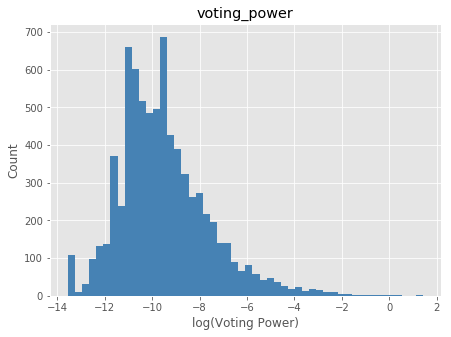

In [34]:
fig, ax = plt.subplots(figsize=(7,5))

plt_df = all_df.copy()#all_df[['source', 'cost_effectiveness']].copy()
plt_df['voting_power'] = np.log(plt_df['voting_power'])
plt_df.hist(column='voting_power', bins=50, color='#4682b4', ax=ax)

#ax.set_xlabel('log(cost_effectiveness) (DALY/1000USD)')
ax.set_xlabel('log(Voting Power)')
ax.set_ylabel('Count')

plt.show()

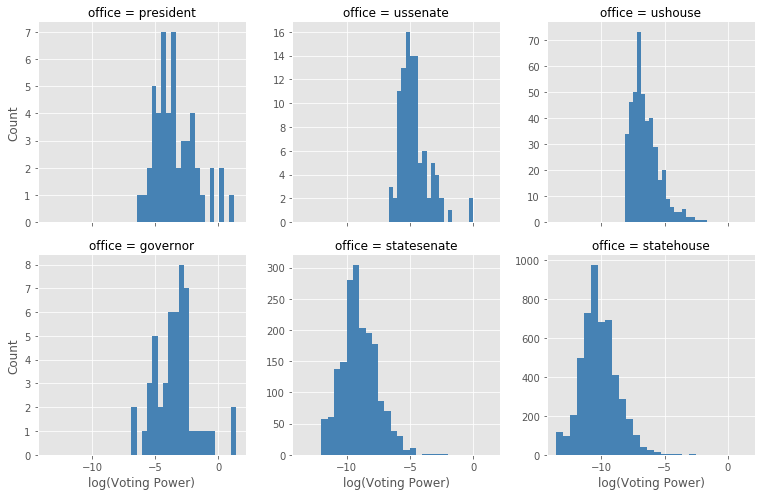

In [35]:
g = sns.FacetGrid(plt_df,  col="office", col_wrap=3,  size=3.5, sharey=False)  #sharey=False
g = g.map(plt.hist, "voting_power", bins=20, color='#4682b4')  
#g = g.map(sns.kdeplot, "voting_power", color='#4682b4')
g.set_axis_labels("log(Voting Power)", "Count")

In [36]:
#pd.concat(g for _, g in all_df.groupby("geoid") if len(g) > 1)

In [37]:
# GEOIDs aren't unique for every geography, only for each race and geography
# ss_df[ss_df.state_abbr == 'WY'].sort_values(by='geoid')
# sh_df[sh_df.state_abbr == 'WY'].sort_values(by='geoid')

In [38]:
# Output CSV
# cols = ['geoid','state_abbr', 'office','year', 'abs_margin',
#     'dem_margin', 'power', 'voting_power' ]
# all_df.to_csv(os.path.join(os.getcwd(), 'data', 'output', 'voting_power.csv'),
#     columns=cols, index=False)